In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35039,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:38435,Total threads: 8
Dashboard: http://127.0.0.1:35885/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:42159,


In [14]:
import xarray as xr
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_ADCP.nc'
ds_adcp = xr.open_dataset(profile_path)
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_CUR.nc'
ds_cur = xr.open_dataset(profile_path)

In [15]:
import pandas as pd
# Combine date and time into a datetime array
dates = ds_adcp['prof_YYYYMMDD'].values.astype(int)
times = ds_adcp['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_adcp = ds_adcp.assign_coords(time=('iPROF', datetimes))
# ds_adcp = ds_adcp.swap_dims({'iPROF': 'time'})
ds_adcp = ds_adcp.assign_coords(depth=('iDEPTH', ds_adcp['prof_depth'].values*-1))
# ds_adcp = ds_adcp.swap_dims({'iDEPTH': 'depth'})
ds_adcp = ds_adcp.assign_coords(lat=('iPROF', ds_adcp['prof_lat'].values))
ds_adcp = ds_adcp.assign_coords(lon=('iPROF', ds_adcp['prof_lon'].values))
# ds_adcp.set_index(lat='lat', lon='lon')
# Combine date and time into a datetime array
dates = ds_cur['prof_YYYYMMDD'].values.astype(int)
times = ds_cur['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_cur = ds_cur.assign_coords(time=('iPROF', datetimes))
# ds_cur = ds_cur.swap_dims({'iPROF': 'time'})
ds_cur = ds_cur.assign_coords(depth=('iDEPTH', ds_cur['prof_depth'].values*-1))
# ds_cur = ds_cur.swap_dims({'iDEPTH': 'depth'})
ds_cur = ds_cur.assign_coords(lat=('iPROF', ds_cur['prof_lat'].values))
ds_cur = ds_cur.assign_coords(lon=('iPROF', ds_cur['prof_lon'].values))
# ds_cur.set_index(lat='lat', lon='lon')

In [16]:
print(ds_adcp)

<xarray.Dataset> Size: 73MB
Dimensions:        (iPROF: 35228, iDEPTH: 62)
Coordinates:
    time           (iPROF) datetime64[ns] 282kB 2011-12-31T01:30:00 ... 2012-...
    depth          (iDEPTH) float64 496B -10.0 -15.0 -20.0 ... -310.0 -315.0
    lat            (iPROF) float64 282kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon            (iPROF) float64 282kB 250.0 250.0 250.0 ... 190.0 190.0 190.0
Dimensions without coordinates: iPROF, iDEPTH
Data variables:
    prof_YYYYMMDD  (iPROF) float64 282kB 2.011e+07 2.011e+07 ... 2.012e+07
    prof_HHMMSS    (iPROF) float64 282kB 1.3e+04 1.3e+04 ... 2.23e+05 2.23e+05
    prof_lon       (iPROF) float64 282kB 250.0 250.0 250.0 ... 190.0 190.0 190.0
    prof_lat       (iPROF) float64 282kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    prof_depth     (iDEPTH) float64 496B 10.0 15.0 20.0 ... 305.0 310.0 315.0
    prof_descr     (iPROF) |S30 1MB ...
    prof_U         (iPROF, iDEPTH) float64 17MB ...
    prof_Uweight   (iPROF, iDEPTH) float64 17

<DatasetGroupBy, grouped over 1 grouper(s), 4 groups in total:
    'lon': 4/4 groups present with labels 165.0, 190.0, 220.0, 250.0>


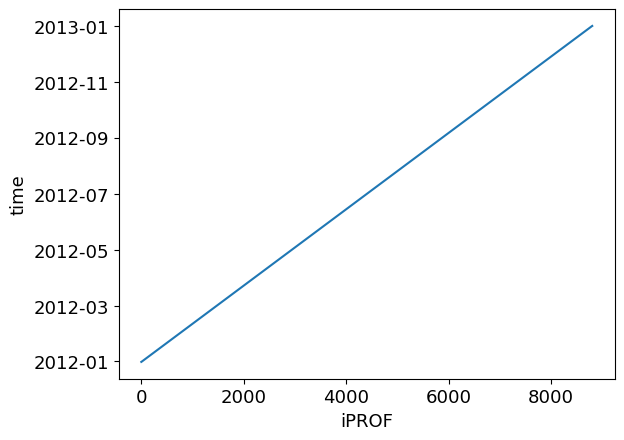

In [41]:
# group profiles by longitude (these are all equatorial TAO moorings)
adcp_by_lon = ds_adcp.groupby('lon')
# check that for a single longitude, time is monotonically increasing 
print(adcp_by_lon)
adcp_by_lon[220.0].time.plot()

<DatasetGroupBy, grouped over 1 grouper(s), 3 groups in total:
    'lon': 3/3 groups present with labels 147.0, 156.0, 190.0>


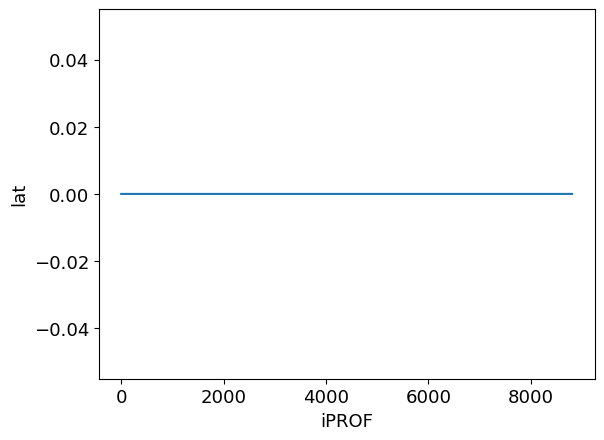

In [35]:
# group profiles by longitude (these are all equatorial TAO moorings)
cur_by_lon = ds_cur.groupby('lon')
# check that for a single longitude, time is monotonically increasing 
print(cur_by_lon)
cur_by_lon[190.0].lat.plot()

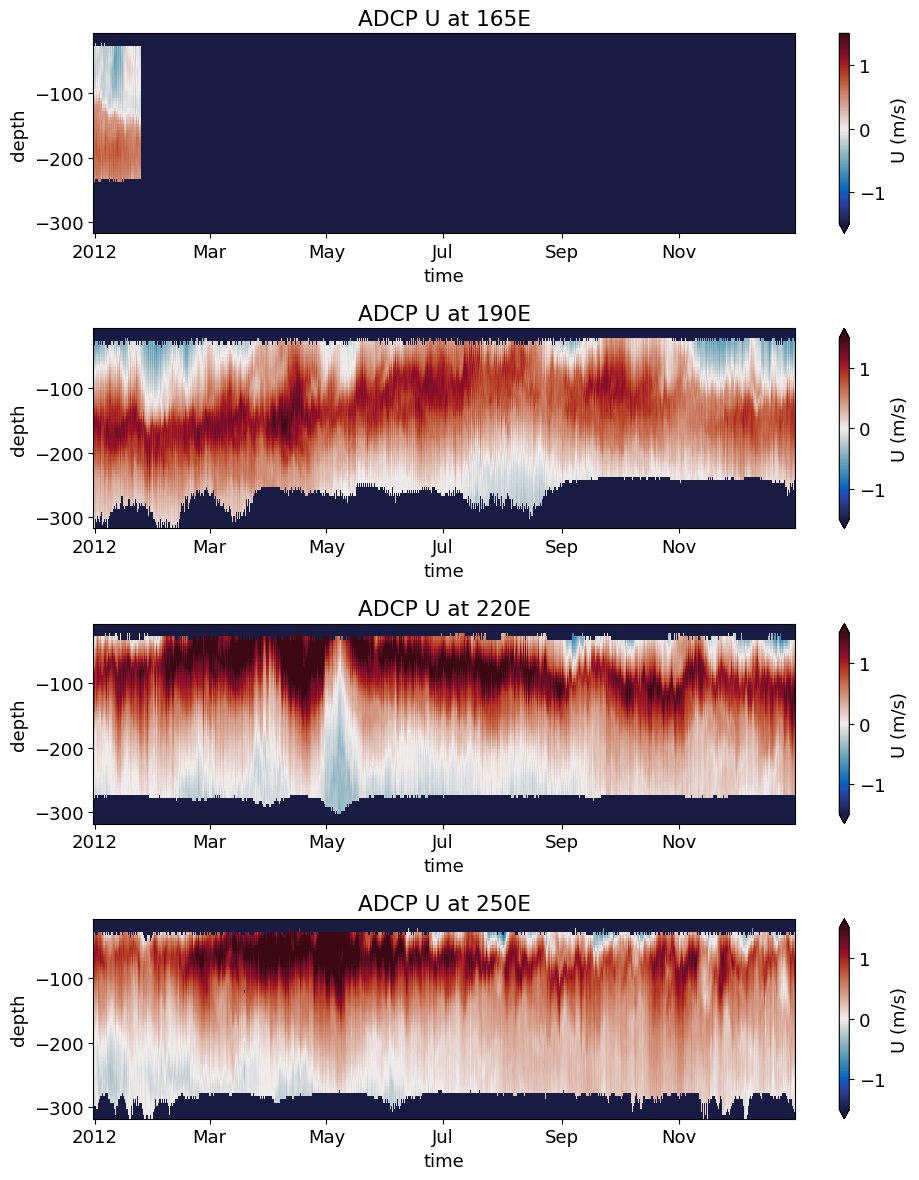

In [46]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import TwoSlopeNorm
import cmocean.cm as cmo
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize=(12,12),nrows=4, ncols=2)
adcp_by_lon[165.0].prof_U.T.plot(ax=ax[0,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0].set_title('ADCP U at 165E')
adcp_by_lon[190.0].prof_U.T.plot(ax=ax[1,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1].set_title('ADCP U at 190E')
adcp_by_lon[220.0].prof_U.T.plot(ax=ax[2,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2].set_title('ADCP U at 220E')
adcp_by_lon[250.0].prof_U.T.plot(ax=ax[3,0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[3].set_title('ADCP U at 250E')

adcp_by_lon[165.0].prof_V.T.plot(ax=ax[0,0],x='time',y='depth',cmap=cmo.balance,vmin=-0.75,vmax=0.75,cbar_kwargs={'label': 'V (m/s)'})
ax[0].set_title('ADCP V at 165E')
adcp_by_lon[190.0].prof_V.T.plot(ax=ax[1,0],x='time',y='depth',cmap=cmo.balance,vmin=-0.75,vmax=0.75,cbar_kwargs={'label': 'V (m/s)'})
ax[1].set_title('ADCP V at 190E')
adcp_by_lon[220.0].prof_V.T.plot(ax=ax[2,0],x='time',y='depth',cmap=cmo.balance,vmin=-0.75,vmax=0.75,cbar_kwargs={'label': 'V (m/s)'})
ax[2].set_title('ADCP V at 220E')
adcp_by_lon[250.0].prof_V.T.plot(ax=ax[3,0],x='time',y='depth',cmap=cmo.balance,vmin=-0.75,vmax=0.75,cbar_kwargs={'label': 'V (m/s)'})
ax[3].set_title('ADCP V at 250E')


plt.tight_layout()
plt.savefig('adcp_profiles_forTPOSE6.png')

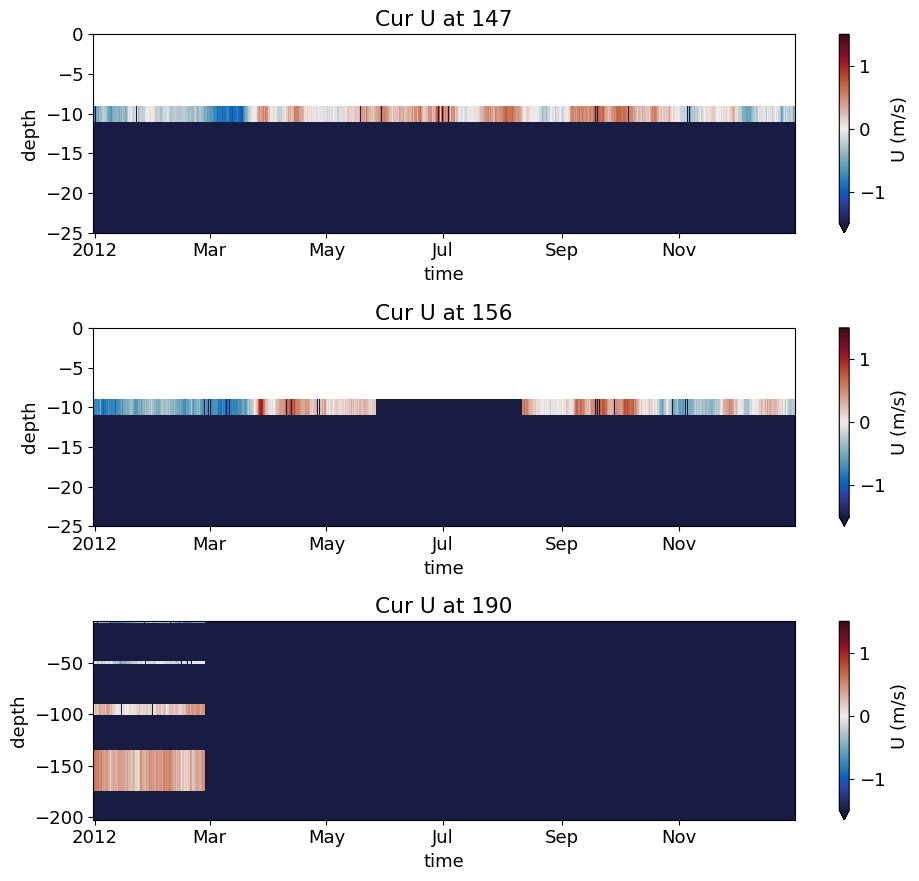

In [47]:
fig, ax = plt.subplots(figsize=(10,9),nrows=3)
cur_by_lon[147.0].prof_U.T.plot(ax=ax[0],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[0].set_ylim(-25,0)
ax[0].set_title('Cur U at 147')
cur_by_lon[156.0].prof_U.T.plot(ax=ax[1],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[1].set_ylim(-25,0)
ax[1].set_title('Cur U at 156')
cur_by_lon[190.0].prof_U.T.plot(ax=ax[2],x='time',y='depth',cmap=cmo.balance,vmin=-1.5,vmax=1.5,cbar_kwargs={'label': 'U (m/s)'})
ax[2].set_title('Cur U at 190')
plt.tight_layout()

In [ ]:
from xmitgcm import open_mdsdataset
data_dir = '/data/SO3/edavenport/tpose6/sep2012/run_iter0/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = ['diag_state']
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200)
# ds['time'] = range(len(ds.time))
# ds['XC'] = ds.XC.astype(float)
# ds['YC'] = ds.YC.astype(float)
# ds['Z'] = ds.Z.astype(float)
# ds['XG'] = ds.XG.astype(float)
# ds['YG'] = ds.YG.astype(float)

: 

In [51]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.colors import TwoSlopeNorm
import cmocean.cm as cmo
warnings.filterwarnings("ignore")
plt.rcParams['font.size'] = 13

#V6_140 = ds.VVEL.interp(XC=[220.0],YG=[V_TAO_140.lat],Z=V_TAO_140.depth,time=V_TAO_140.time,method='linear')

# VADCP_TPOSE = ds.VVEL.interp(XC=ds_adcp.lon,YG=ds_adcp.lon,Z=ds_adcp.depth,time=ds_adcp.time,method='linear')
# UADCP_TPOSE = ds.UVEL.interp_like(ds_adcp,method='linear')
# VCUR_TPOSE = ds.VVEL.interp_like(ds_cur, method='linear')
# UCUR_TPOSE = ds.UVEL.interp_like(ds_cur,method='linear')

In [84]:
ds_adcp.prof_U.sortby('time', ascending=True).T.plot(cmap=cmo.balance, vmin=-1.5, vmax=1.5)

KeyError: "'lon' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'time': 35228, 'depth': 62})"